In [1]:
import time
import pandas as pd
import numpy as np
import scipy.stats as stats
import csep
from csep.utils.plotting import plot_mfd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat')
comcat_count = comcat.get_number_of_events()
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))


Fetched Comcat catalog in 0.9698901176452637 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-06-28 02:33:55.456000+00:00
Min Latitude: 31.597166061401367 and Max Latitude: 41.83566665649414
Min Longitude: -125.38899993896484 and Max Longitude: -113.107666015625
Min Magnitude: 2.5 and Max Magnitude: 6.300000190734863



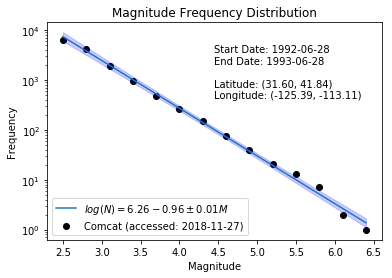

In [3]:
# getting comcat catalog as dataframe 
dm = 0.3
min_mw, max_mw = comcat.min_magnitude, comcat.max_magnitude
mw_inter = arange(min_mw-dm/2, max_mw+dm, dm)

# switching into dataframe for easy manipulations
df = comcat.get_dataframe()

# bind to comcat catalog
# comcat.mfd contains magnitude bins and counts
comcat.mfd = pd.DataFrame(df['counts'].groupby(pd.cut(df['magnitude'], mw_inter)).sum())
comcat.mfd['counts'] = comcat.mfd.loc[::-1, 'counts'].cumsum()

vals_all = squeeze(comcat.mfd.values)
x_all = array(comcat.mfd.index.categories.mid)

# remove zeros from data used to fit (naive solution to log10(0) problem)
id_nonzero = nonzero(vals_all)
vals = vals_all[id_nonzero]
x = x_all[id_nonzero]

# this could evaluate as false if there are zeros
N = log10(squeeze(vals_all))
G = vstack([ones(len(x)), x]).T

# perform least-squares to get b-value
# log(N) = a-bM
# N = 10^a / 10^bM
a, b = linalg.lstsq(G, N, rcond=None)[0]

# generate line to plot
N_est = a + b*x

# setup vars for plotting ci
p_value = 0.05
err = N - squeeze(N_est)

t_stat = stats.t.ppf(1-p_value/2, len(x)-2)
mean_x = mean(x)
n = len(x)
se_line = sqrt(sum(power(err,2))/(n-2))
se_xk = sqrt(1/n+power(x-mean_x,2)/sum(power(x-mean_x,2)))
confs = se_line * se_xk
lower = N_est-t_stat*confs
upper = N_est+t_stat*confs

# confidence interval of b-value
rms = sqrt(mean(power(err,2)))
denom = sum(power(x-mean_x,2))
ci_b = t_stat*rms/denom

# wish this were functional
comcat.mfd['N'] = 0.0
comcat.mfd['N_est'] = 0.0
comcat.mfd['lower_ci'] = 0.0
comcat.mfd['upper_ci'] = 0.0
comcat.mfd['t_stat'] = 0.0
comcat.mfd['a'] = 0.0
comcat.mfd['b'] = 0.0
comcat.mfd['ci_b'] = 0.0
               
# add additional state to dataframe. use .loc() indexing to ensure the data is bound to dataframe
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'N'] = N
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'N_est'] = N_est
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'lower_ci'] = lower
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'upper_ci'] = upper
comcat.mfd.loc[comcat.mfd['counts'] != 0, 't_stat'] = t_stat
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'a'] = a
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'b'] = b
comcat.mfd.loc[comcat.mfd['counts'] != 0, 'ci_b'] = ci_b

               
# plotting
fig, ax = subplots()
ax.scatter(comcat.mfd.index.categories.mid, comcat.mfd['counts'], color='black', label='{} (accessed: {})'
              .format(comcat.name, comcat.date_accessed.date()))
ax.plot(x, 10**N_est, label='$log(N)={}-{}\pm{}M$'.format(round(a,2),round(abs(b),2), round(abs(ci_b),2)))
ax.fill_between(x, 10**lower, 10**upper, color='blue', alpha=0.2)
ax.set_yscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Frequency')
ax.set_title('Magnitude Frequency Distribution')
ax.annotate(s='Start Date: {}\nEnd Date: {}\n\nLatitude: ({:.2f}, {:.2f})\nLongitude: ({:.2f}, {:.2f})'
            .format(comcat.start_time.date(), comcat.end_time.date(),
                   comcat.min_latitude,comcat.max_latitude,
                   comcat.min_longitude,comcat.max_longitude),
            xycoords='axes fraction', xy=(0.5, 0.65), fontsize=10)
ax.legend(loc='lower left')
savefig('comcat_mfd.pdf')

In [4]:
comcat.mfd

,counts,N,N_est,lower_ci,upper_ci,t_stat,a,b,ci_b
magnitude,,,,,,,,,
"(2.35, 2.65]",6251,3.795949,3.870072,3.780939,3.959206,2.178813,6.262737,-0.957066,0.007948
"(2.65, 2.95]",4246,3.627980,3.582953,3.503485,3.662420,2.178813,6.262737,-0.957066,0.007948
"(2.95, 3.25]",1945,3.288920,3.295833,3.225427,3.366239,2.178813,6.262737,-0.957066,0.007948
"(3.25, 3.55]",976,2.989450,3.008713,2.946500,3.070926,2.178813,6.262737,-0.957066,0.007948
"(3.55, 3.85]",482,2.683047,2.721593,2.666315,2.776871,2.178813,6.262737,-0.957066,0.007948
"(3.85, 4.15]",267,2.426511,2.434473,2.384349,2.484598,2.178813,6.262737,-0.957066,0.007948
"(4.15, 4.45]",150,2.176091,2.147354,2.100016,2.194691,2.178813,6.262737,-0.957066,0.007948
"(4.45, 4.75]",76,1.880814,1.860234,1.812897,1.907571,2.178813,6.262737,-0.957066,0.007948
"(4.75, 5.05]",40,1.602060,1.573114,1.522990,1.623238,2.178813,6.262737,-0.957066,0.007948


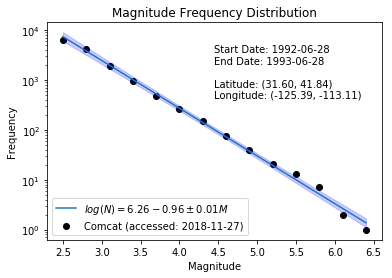

In [6]:
# test implementation
# comcat.mfd
mfd = comcat.get_mfd()
plot_mfd(comcat)